In [1]:
# Ref.)
# https://github.com/Shedka/citiesatnight/blob/5f17f1b323740cea77623ad038a8e713c25849db/frqi.py
# https://arxiv.org/pdf/1812.11042.pdf
# https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms

%matplotlib inline

def genGraycode(nbit):
    graycode = ['0', '1']

    for _ in range(nbit-1):
        mirrored = reversed(graycode)
        graycode = ['0'+g for g in graycode]
        graycode = graycode + ['1'+m for m in mirrored]
    
    return graycode

def MCRY(theta, n_controlbit):
    t = 2**(n_controlbit + 1)
    mat = np.identity(t)
    # higher qubit indices are more significant (little endian convention)
    #      ┌───┐
    # q_0: ┤ X ├
    #      └─┬─┘
    # q_1: ──■──
    #        │
    # q_2: ──■──
    # mat[t-2, t-2] = np.cos(np.pi/4)
    # mat[t-2, t-1] = -np.sin(np.pi/4)
    # mat[t-1, t-2] = np.sin(np.pi/4)
    # mat[t-1, t-1] = np.cos(np.pi/4)

    # q_0: ──■──
    #        │
    # q_1: ──■──
    #      ┌─┴─┐
    # q_2: ┤ X ├
    #      └───┘
    mat[t//2-1, t//2-1] = np.cos(theta/2)
    mat[t//2-1, t-1] = -np.sin(theta/2)
    mat[t-1, t//2-1] = np.sin(theta/2)
    mat[t-1, t-1] = np.cos(theta/2)

    return UnitaryGate(mat, label=f'theta={theta}')

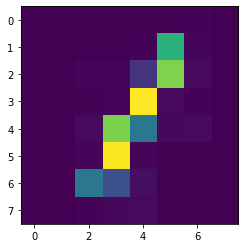

In [2]:
# img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/0/"
# img_path = img_folder + "1.jpg"
img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/1/"
img_path = img_folder + "3.jpg"

img = cv2.imread(img_path, 0)

""" image reszie from 28x28 to 32x32 """
img_size = 8
img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)

""" Image Visualization """
plt.imshow(img)
plt.show()

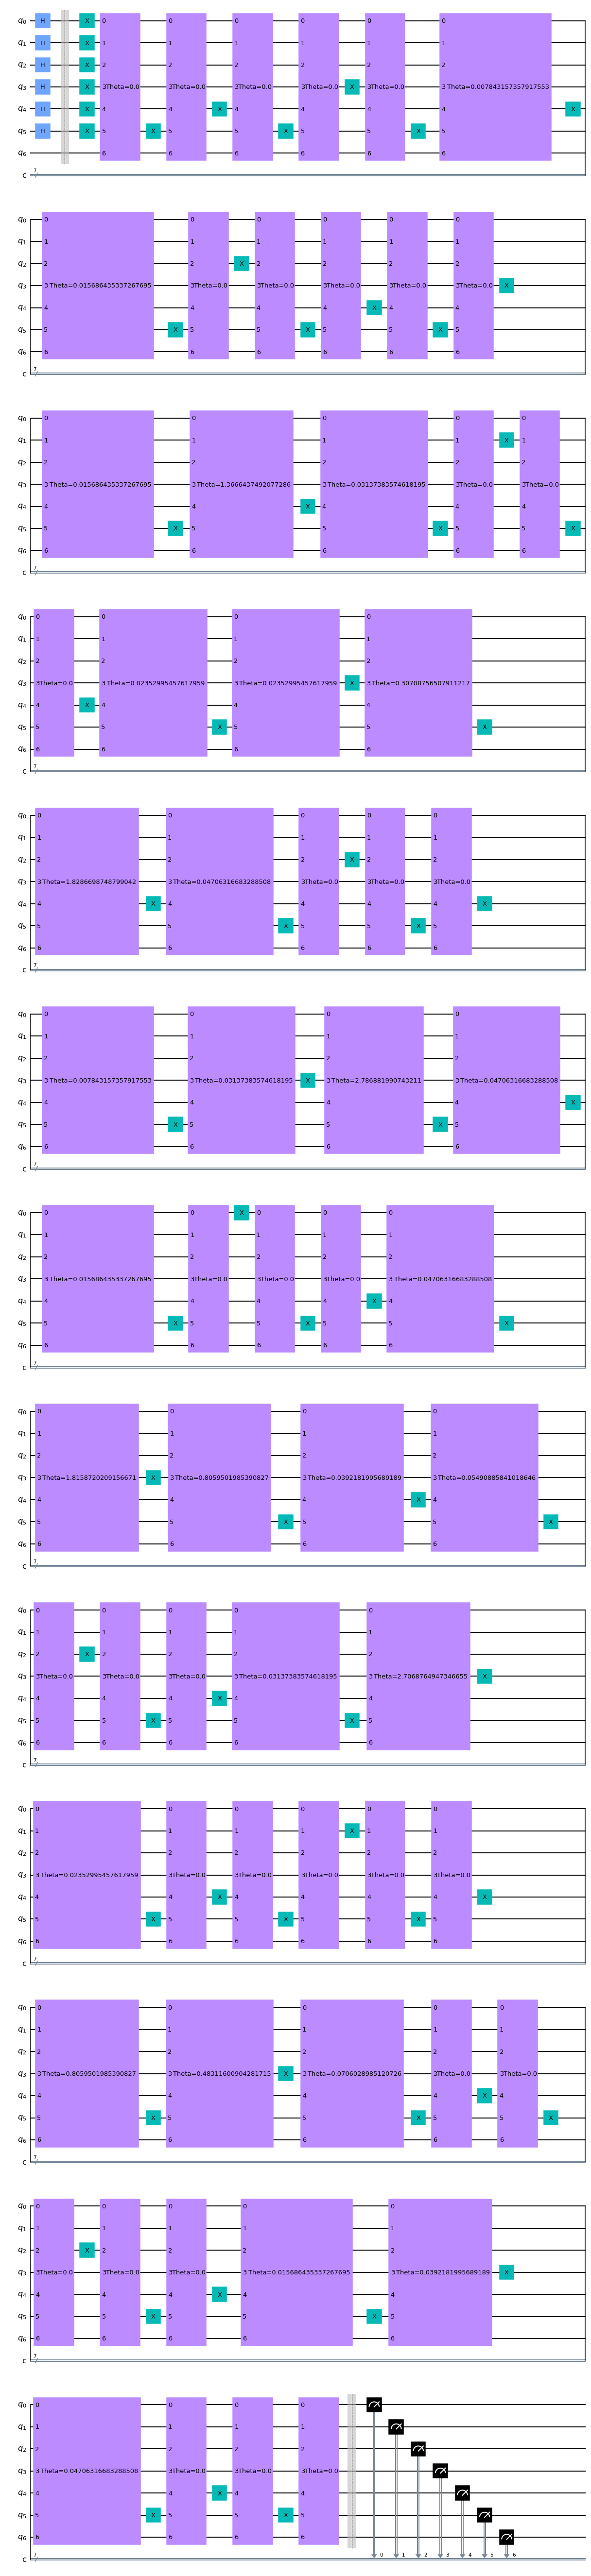

In [3]:
""" 2d to 1d """
img = img.reshape(img_size*img_size)

""" Nomralization (0~1 == sin(0)~sin(pi/2)) """
img = img / 255.0

""" calculate theta """
img = np.arcsin(img)

# provider = IBMQ.load_account()


""" Create Multi-controlled RY Gate """
k = int(np.ceil(np.log2(img_size)))

""" Design circuit """
qc = QuantumCircuit(2*k+1, 2*k+1)

qc.h(range(0, 2*k))

graycode = genGraycode(2*k)

qc.barrier()
for i, e in enumerate(img):
    if i == 0:
        qc.x(range(0, 2*k))
    else:
        for j in range(2*k):
            if graycode[i-1][j] != graycode[i][j]:
                qc.x(j)
                break
    mcry = MCRY(2 * img[i], 2*k)
    qc.append(mcry, range(0, 2*k+1))

qc.barrier()
    
qc.measure(range(2*k+1), range(2*k+1))

# qc = qc.reverse_bits()

qc.draw(output='mpl')

C:\Users\thesi\anaconda3\envs\qiskit_0_23_5\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
<ipython-input-4-60b32c41f4ca>:5: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})


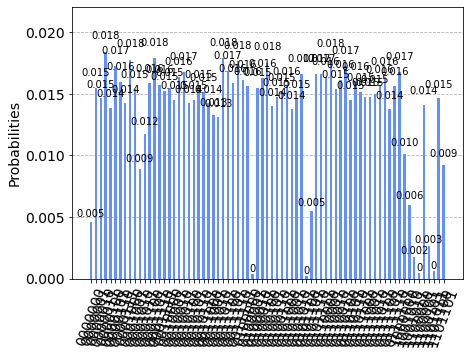

In [4]:
""" run simulator """
provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count = result.get_counts()
plot_histogram(count)

[68.6440678   3.10077519  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         98.31932773  0.          0.          0.          0.
  0.          0.         40.33613445  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         97.4137931   0.          0.
  0.          0.          0.          0.          0.         15.78947368
  0.          0.          0.         62.71186441  0.          0.
  0.          0.          0.          0.         12.96296296  3.62318841
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


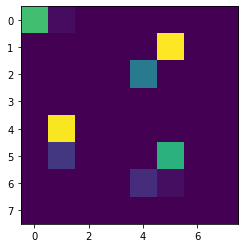

In [12]:
""" decode """
genimg = []
# for i in range(0, img_size*img_size):
#     print('{0:06b}'.format(i))
for i in range(0, img_size*img_size):
    b = '{0:06b}'.format(i)[::-1]
    b0 = count.get('0'+b)
    if b0 == None:
        b0 = 0.
    b1 = count.get('1'+b)
    if b1 == None:
        b1 = 0.
    try:
        genimg = np.append(genimg, b1*100/(b0+b1))
    except:
        genimg = np.append(genimg, 0.)
#     try:
#         genimg = np.append(genimg, count.pop('1'+'{0:06b}'.format(i)))
#     except:
#         try:
#             genimg = np.append(genimg, count.pop('0'+'{0:06b}'.format(i)))
#         except:
#             genimg = np.append(genimg, [0.])
print(genimg)
genimg = genimg * 32. *255.
genimg = genimg.astype('int')
genimg = genimg.reshape((img_size, img_size))
plt.imshow(genimg)
plt.show()

In [6]:
print(count)
print(type(count))

{'0000000': 37, '0000001': 124, '0010000': 124, '0010001': 116, '0010010': 131, '0010011': 134, '0010100': 114, '0010101': 116, '0010110': 123, '0010111': 121, '0011000': 114, '0011001': 106, '0011010': 105, '0011011': 143, '0011100': 135, '0011101': 127, '0011110': 141, '0011111': 129, '0000010': 117, '0100000': 125, '0100001': 3, '0100010': 124, '0100011': 130, '0100100': 140, '0100101': 112, '0100110': 118, '0100111': 121, '0101000': 125, '0101001': 110, '0101010': 117, '0101011': 133, '0101100': 2, '0101101': 44, '0101110': 133, '0101111': 133, '0000011': 147, '0110000': 131, '0110001': 142, '0110010': 123, '0110011': 129, '0110100': 138, '0110101': 116, '0110110': 128, '0110111': 121, '0111000': 118, '0111001': 118, '0111010': 120, '0111011': 126, '0111100': 131, '0111101': 110, '0111110': 125, '0111111': 134, '0000100': 111, '1000000': 81, '1001010': 48, '1001011': 14, '0000101': 138, '0000110': 128, '1100000': 4, '1100001': 113, '1100101': 21, '1101011': 5, '1101100': 117, '1101

In [7]:
bin(img_size*img_size)

'0b1000000'